In [ ]:
from google.colab import files

uploaded = files.upload()


Saving E-Commerce Data.csv to E-Commerce Data.csv


In [ ]:
import pandas as pd

# Try reading the file with a different encoding
df = pd.read_csv('/content/drive/MyDrive/445 datasets/E-Commerce Data.csv', encoding='latin-1')
# or 'iso-8859-1', depending on the actual encoding of the file

df = df.dropna()  # Drop missing values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Import pandas to work with dataframes

# Try reading the file with a different encoding
df = pd.read_csv('/content/drive/MyDrive/445 datasets/E-Commerce Data.csv', encoding='latin-1')
# or 'iso-8859-1', depending on the actual encoding of the file

df = df.dropna()  # Drop missing values

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract features (you may need to select appropriate features and preprocess them)
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

# Encode categorical variables
le = LabelEncoder()
df['StockCode'] = le.fit_transform(df['StockCode'])
df['Description'] = le.fit_transform(df['Description'])
df['Country'] = le.fit_transform(df['Country'])

# Define a binary target variable (Example: Large transaction if Quantity > 50)
df['LargeTransaction'] = (df['Quantity'] > 50).astype(int)

# Define features and target variable
X = df.drop(['Quantity', 'InvoiceDate', 'LargeTransaction'], axis=1)
y = df['LargeTransaction']

# Split the data into training and testing sets (using a smaller subset for efficiency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For efficiency, we'll further sample the training data
X_train_sampled = X_train.sample(n=5000, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

In [ ]:
import time
import psutil
from sklearn.ensemble import GradientBoostingClassifier

# Record the start time and CPU + RAM usage
start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
ram_start = psutil.virtual_memory().used / (1024**3)  # in GB

# Initialize and train the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Convert the encoded 'StockCode' feature to numeric type, handling potential non-numeric values
# Instead of filling non-numeric values with 0, drop the rows with non-numeric 'StockCode' values
X_train_sampled = X_train_sampled[pd.to_numeric(X_train_sampled['StockCode'], errors='coerce').notnull()]
X_train_sampled['StockCode'] = X_train_sampled['StockCode'].astype(int)

# Explicitly convert ALL columns to numeric, coercing errors
for col in X_train_sampled.columns:
    X_train_sampled[col] = pd.to_numeric(X_train_sampled[col], errors='coerce')

# Drop any rows with missing values after conversion
X_train_sampled = X_train_sampled.dropna()

# Re-index y_train_sampled to match the updated X_train_sampled after dropping rows
y_train_sampled = y_train_sampled.loc[X_train_sampled.index]

gb.fit(X_train_sampled, y_train_sampled)

# Record the end time and CPU + RAM usage
cpu_end = psutil.cpu_percent(interval=None)
ram_end = psutil.virtual_memory().used / (1024**3)  # in GB
end_time = time.time()

# Calculate the training time and resource usage
training_time = end_time - start_time
cpu_usage = cpu_end - cpu_start
ram_usage = ram_end - ram_start

print(f"Training time: {training_time} seconds")
print(f"CPU usage: {cpu_usage}%")
print(f"RAM usage: {ram_usage} GB")

Training time: 1.9398620128631592 seconds
CPU usage: 75.0%
RAM usage: 0.01384735107421875 GB


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

# Initialize Randomized Search
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_distributions, cv=3, n_jobs=-1, verbose=2, n_iter=10)

# Perform Randomized Search
random_search.fit(X_train_sampled, y_train_sampled)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


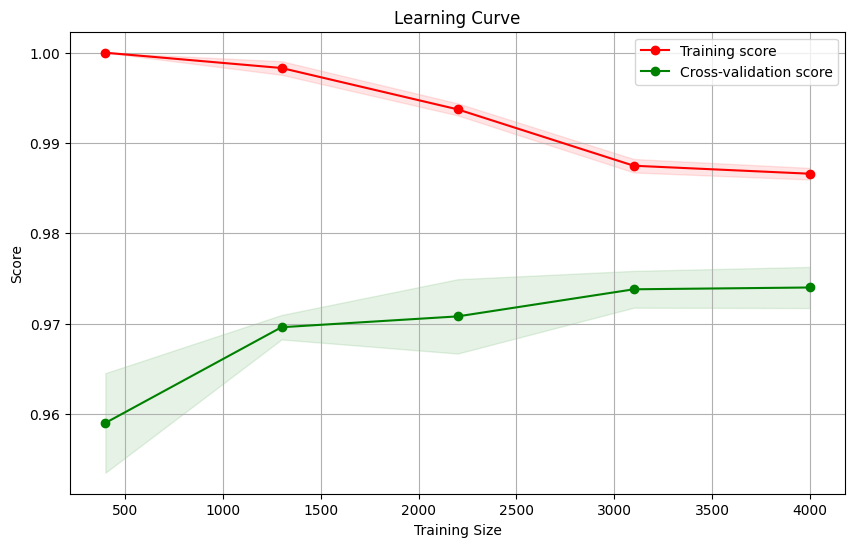

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Gradient Boosting model (redefining 'gb' to ensure it's available in this cell)
gb = GradientBoostingClassifier(random_state=42)

# Generate the learning curve (using fewer points for efficiency)
train_sizes, train_scores, test_scores = learning_curve(gb, X_train_sampled, y_train_sampled, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('Learning_Curve_Gradient_Boosting.png')
plt.show()

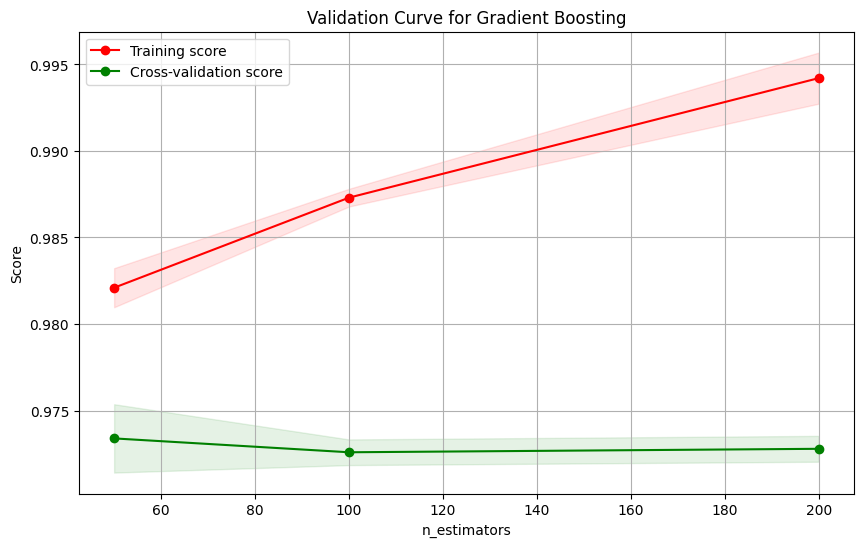

In [ ]:
from sklearn.model_selection import validation_curve

# Example: Effect of `n_estimators` regularization parameter (using fewer points for efficiency)
param_range = [50, 100, 200]
train_scores, test_scores = validation_curve(gb, X_train_sampled, y_train_sampled, param_name="n_estimators", param_range=param_range, cv=3, n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(param_range, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Validation Curve for Gradient Boosting')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('Validation_Curve_n_estimators_Gradient_Boosting.png')
plt.show()

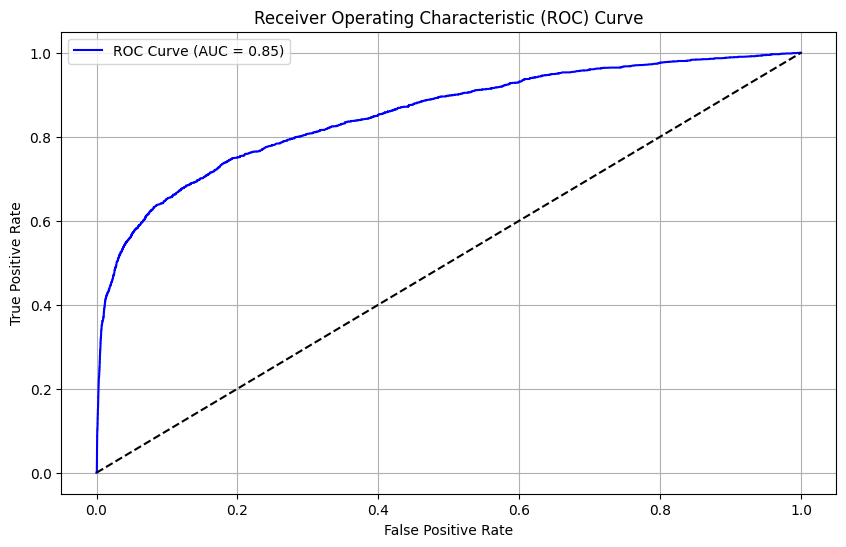

Accuracy: 0.97
Precision: 0.64
Recall: 0.25
F1 Score: 0.36
AUC: 0.85


In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt # Import the matplotlib library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Assuming X_test is your test dataset
# Convert the encoded 'StockCode' feature to numeric type, handling potential non-numeric values
X_test = X_test[pd.to_numeric(X_test['StockCode'], errors='coerce').notnull()]
X_test['StockCode'] = X_test['StockCode'].astype(int)

# Explicitly convert ALL columns to numeric, coercing errors
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Store the original index before dropping rows
original_index = X_test.index

# Drop any rows with missing values after conversion
X_test = X_test.dropna()

# Adjust y_test to match the updated X_test after dropping rows
y_test = y_test.loc[X_test.index]  # Select the y_test values corresponding to remaining X_test indices

# Now try making predictions again
y_pred = gb.predict(X_test)

# Predict probabilities
y_pred_proba = gb.predict_proba(X_test)[:, 1]  # Assuming binary classification, take probabilities for class 1


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Assuming y_pred_proba is available from a previous step where probabilities were predicted
auc = roc_auc_score(y_test, y_pred_proba)


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6)) # Now plt is defined and can be used
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()
plt.savefig('ROC_Curve_Gradient_Boosting.png')
plt.show()

# ... (rest of your code)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")